In [1]:
import intake
from easygems import healpix as egh

import matplotlib.pyplot as plt
import numpy as np

import warnings

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

In [2]:
import cmocean

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
import xarray as xr

In [5]:
loc_um_1H_z7 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z7.zarr/" #PT1H is hourly data
loc_um_3H_z7 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT3H.z7.zarr/" #PT1H is hourly data
loc_icon_daily_z7 = "/g/data/qx55/germany_node/d3hp003.zarr/P1D_mean_z7_atm.zarr/" #PT1H is hourly data

um_data = xr.open_zarr(loc_um_1H_z7)
um_data_3d = xr.open_zarr(loc_um_3H_z7)
icon_data = xr.open_zarr(loc_icon_daily_z7)

In [6]:
from dask.diagnostics import ProgressBar

In [7]:
with ProgressBar():
    icon_daily_loaded = (icon_data.pr*86400).sel(time = slice('2020-03-01', '2021-03-01')).load()
# egh.healpix_show(icon_daily_z5.pr.mean('time'), cmap=cmocean.cm.deep)

[########################################] | 100% Completed | 406.97 ms


In [8]:
with ProgressBar():
    icon_clt_daily_loaded = (icon_data.clt).load()
# egh.healpix_show(icon_daily_z5.pr.mean('time'), cmap=cmocean.cm.deep)

[########################################] | 100% Completed | 411.19 ms


In [21]:
with ProgressBar():
    icon_rlut_daily_loaded = (icon_data.rlut.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()
    icon_rsut_daily_loaded = (icon_data.rsut.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()

[########################################] | 100% Completed | 617.34 ms
[########################################] | 100% Completed | 623.62 ms


In [22]:
with ProgressBar():
    um_daily_loaded = (um_data.pr.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time=24, boundary='trim').mean('time')*86400).load()
# egh.healpix_show(um_z5_t1h.pr.coarsen(time=24, boundary='trim').mean('time').mean('time'), cmap=cmocean.cm.deep)

[########################################] | 100% Completed | 11.30 s


In [23]:
with ProgressBar():
    um_clt_daily_loaded = (um_data.clt.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()

[########################################] | 100% Completed | 10.68 s


In [24]:
with ProgressBar():
    um_rlut_daily_loaded = (um_data.rlut.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()
    um_rsut_daily_loaded = (um_data.rsut.sel(time = slice('2020-03-01', '2021-03-01')).coarsen(time = 24, boundary='trim').mean('time')).load()

[########################################] | 100% Completed | 11.09 s
[########################################] | 100% Completed | 11.13 s


In [67]:
def plot_data(data, cmap=cmocean.cm.deep, vmin=0, vmax=10, cbar_extend='both', aspect=45, cbar_orientation='horizontal', cbar_shrink=1.0,  plot_title='ICON model', cbar_label='Precip (mm/day)'):
    projection = ccrs.Robinson(central_longitude=160)
    ax = egh.create_geoaxis(add_coastlines=True, projection=projection)
    im = egh.healpix_show(data.values, cmap=cmap, vmin=vmin, vmax=vmax, add_coastlines=True, ax=ax)
    gl = ax.gridlines(alpha=0., draw_labels=True)
    gl.right_labels=False
    gl.top_labels=False
    ax.set_title(plot_title)
    # fig = ax.get_figure()
    plt.colorbar(im, orientation=cbar_orientation, extend=cbar_extend, aspect=aspect, shrink=cbar_shrink, label=cbar_label)

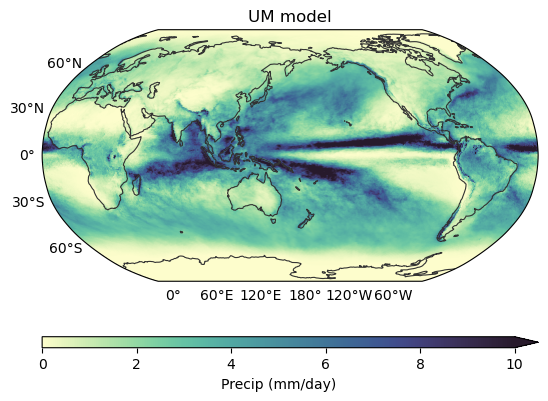

In [41]:
plot_data(um_daily_loaded.mean('time'), plot_title='UM model', cbar_extend='max')

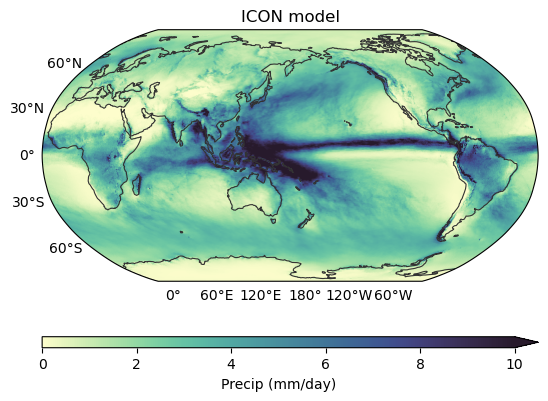

In [42]:
plot_data(icon_daily_loaded.mean('time'), plot_title='ICON model', cbar_extend='max')

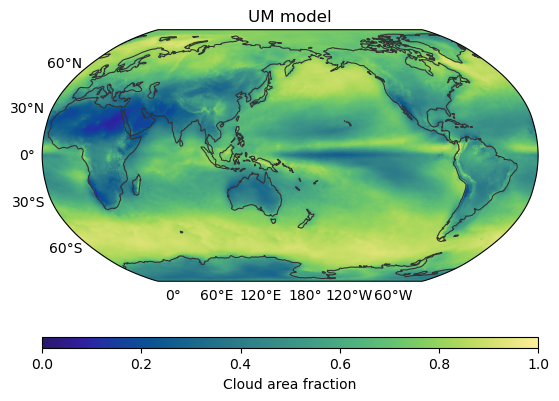

In [17]:
plot_data(um_clt_daily_loaded.mean('time'), cmap=cmocean.cm.haline, vmin=0, vmax=1, cbar_extend='neither', aspect=45, cbar_orientation='horizontal', cbar_shrink=1.0,  plot_title='UM model', cbar_label='Cloud area fraction')

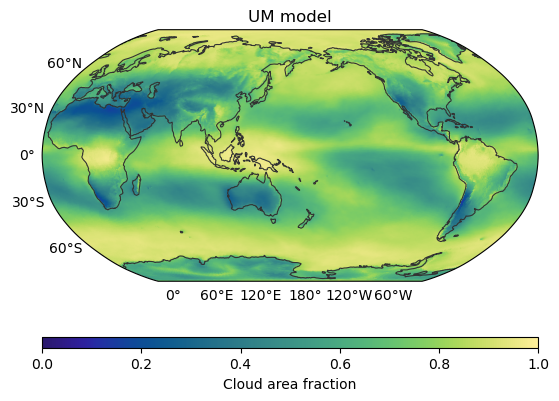

In [18]:
plot_data(icon_clt_daily_loaded.mean('time'), cmap=cmocean.cm.haline, vmin=0, vmax=1, cbar_extend='neither', aspect=45, cbar_orientation='horizontal', cbar_shrink=1.0,  plot_title='UM model', cbar_label='Cloud area fraction')

In [31]:
import numpy as np

In [70]:
icon_strat_regime = xr.where((icon_clt_daily_loaded.sel(time = slice('2020-06-01', '2020-07-01')).mean('time') > 0.5) & (icon_daily_loaded.sel(time = slice('2020-06-01', '2020-07-01')).mean('time') < 1.0), 1, np.nan)

icon_mod_conv_regime = xr.where((icon_clt_daily_loaded.sel(time = slice('2020-06-01', '2020-07-01')).mean('time') < 0.25) & (icon_daily_loaded.sel(time = slice('2020-06-01', '2020-07-01')).mean('time') > 1.5) & (icon_daily_loaded.sel(time = slice('2020-06-01', '2020-07-01')).mean('time') < 6), 0, np.nan)

icon_strong_conv_regime = xr.where(icon_daily_loaded.sel(time = slice('2020-06-01', '2020-07-01')).mean('time') > 8, -1, np.nan)


# icon_regimes = icon_strat_regime + icon_mod_conv_regime + icon_strong_conv_regime

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (4126984545.py, line 2)

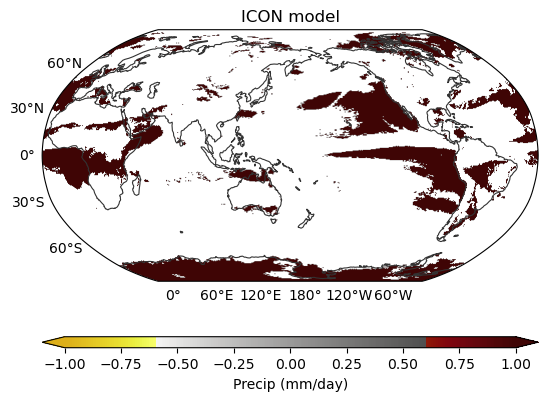

In [69]:
plot_data(icon_strat_regime, vmin=-1, vmax=1, cmap=cmocean.cm.oxy_r)

<Figure size 640x480 with 0 Axes>

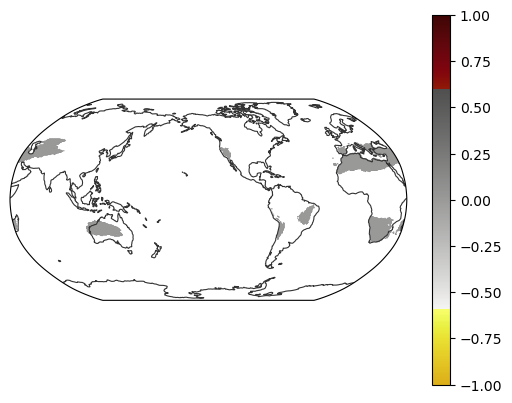

In [65]:
cf = egh.healpix_show(icon_mod_conv_regime, vmin=-1, vmax=1, cmap=cmocean.cm.oxy_r)
plt.colorbar(cf)

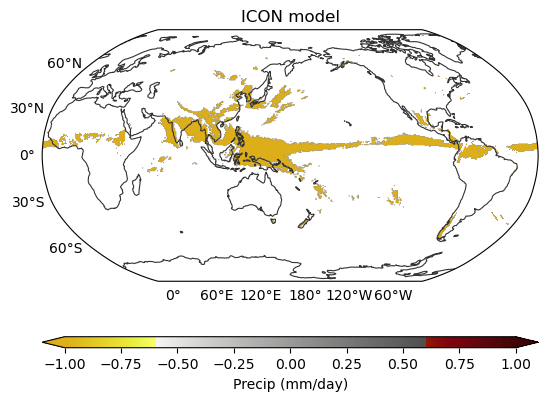

In [71]:
plot_data(icon_strong_conv_regime, vmin=-1, vmax=1, cmap=cmocean.cm.oxy_r)

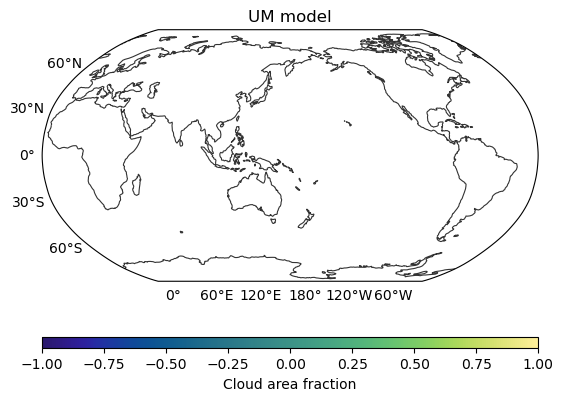

In [131]:
plot_data(icon_regimes, cmap=cmocean.cm.haline, vmin=-1, vmax=1, cbar_extend='neither', aspect=45, cbar_orientation='horizontal', cbar_shrink=1.0,  plot_title='UM model', cbar_label='Cloud area fraction')